In [3]:
import pandas as pd
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_3.csv"

try:
    # Load the dataset from the CSV file

    df_2d_features = pd.read_csv(file_path)

    # --- Part 1: Value counts for categorical columns ---
    print("--- Value Counts for Categorical Columns ---")

    # List of categorical columns to analyze
    categorical_columns = [
        'PD_or_C',
        'number_of_turning_steps',
        'turning_angle',
        'type_of_turn',
        'On_or_Off_medication',
        'DBS_state'
    ]

    # Loop through each column and print its value counts
    for column in categorical_columns:
        print(f"\n--- Categories in '{column}' ---")
        print(df_2d_features[column].value_counts())
        print("\n" + "="*40)

    # --- Part 2: Number of turns for each unique combination ---
    print("\n--- Number of turns for each unique combination ---")

    # Define the columns for which you want to find combinations
    combination_columns = [
        'PD_or_C',
        'turning_angle',
        'type_of_turn',
        'On_or_Off_medication',
        'DBS_state'
    ]

    # Group by the specified columns, count the occurrences, and sort the results
    combination_counts = df_2d_features.groupby(combination_columns).size().reset_index(name='count')
    combination_counts_sorted = combination_counts.sort_values(by='count', ascending=False)

    # Use a context manager to temporarily set display options to show all rows
    with pd.option_context('display.max_rows', None):
        print(combination_counts_sorted)

except FileNotFoundError:
    print("Error: 'cleaned_turning_project_2d_features.csv' not found.")
    print("Please make sure the CSV file is in the same directory as this script.")

except Exception as e:
    print(f"An error occurred: {e}")

--- Value Counts for Categorical Columns ---

--- Categories in 'PD_or_C' ---
PD_or_C
PD    1628
C      743
Name: count, dtype: int64


--- Categories in 'number_of_turning_steps' ---
number_of_turning_steps
2     1138
3      582
1      357
4      200
5       56
6       16
7        5
10       4
13       3
8        3
9        2
11       2
12       1
16       1
18       1
Name: count, dtype: int64


--- Categories in 'turning_angle' ---
turning_angle
90_degrees     1617
180_degrees     535
135_degrees     212
225_degrees       5
270_degrees       1
360_degrees       1
Name: count, dtype: int64


--- Categories in 'type_of_turn' ---
type_of_turn
pivot_turn    2105
step_turn      229
-               37
Name: count, dtype: int64


--- Categories in 'On_or_Off_medication' ---
On_or_Off_medication
On medication     1175
Control            743
Off medication     453
Name: count, dtype: int64


--- Categories in 'DBS_state' ---
DBS_state
Control    743
-          705
On DBS     467
Off DBS    4

✅ Successfully loaded data from 'D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_3.csv'

Class distribution for the model:
Subgroup
PD_On_Med_No_DBS     442
Control              392
PD_On_Med_DBS_On     324
PD_Off_Med_No_DBS    324
Name: count, dtype: int64
Original training set distribution:
 Subgroup
PD_On_Med_No_DBS     309
Control              274
PD_On_Med_DBS_On     227
PD_Off_Med_No_DBS    227
Name: count, dtype: int64

Resampled training set distribution:
 Subgroup
PD_Off_Med_No_DBS    309
PD_On_Med_DBS_On     309
Control              309
PD_On_Med_No_DBS     309
Name: count, dtype: int64

✅ Model training complete on resampled data.

          Model Evaluation Results (After SMOTE)
Overall Accuracy: 51.01%

Classification Report:
                   precision    recall  f1-score   support

          Control       0.59      0.56      0.58       118
PD_Off_Med_No_DBS       0.55      0.71      0.62        97
 PD_On_Med_DBS_On       0.52      0.61      

D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



✅ Confusion matrix plot saved as 'confusion_matrix_with_steps.png'


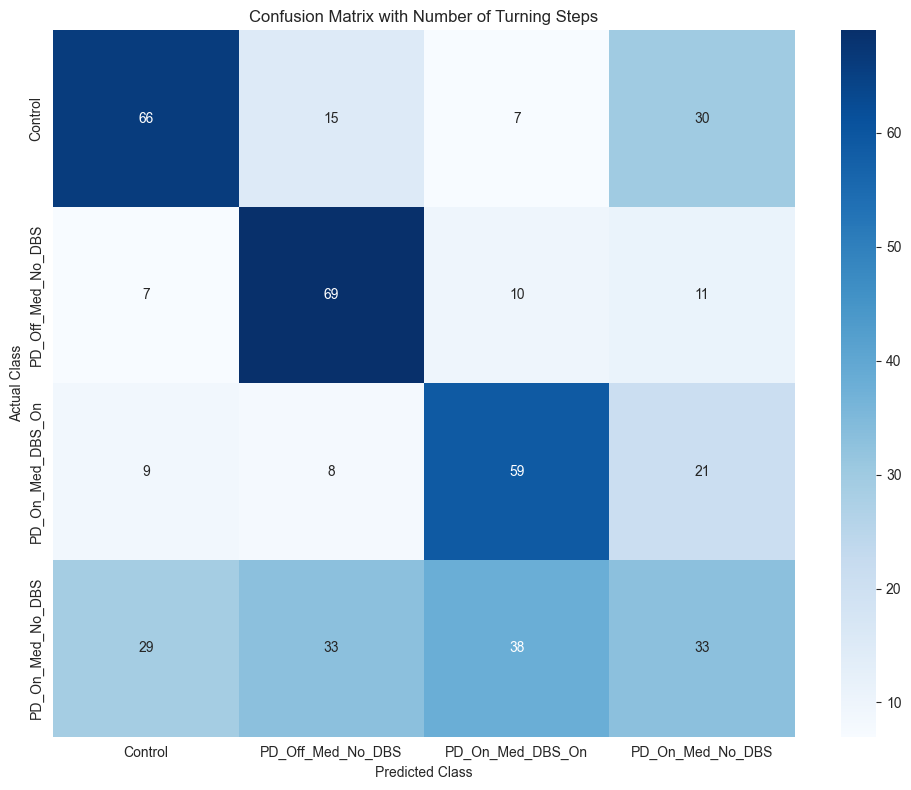

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Data ---

try:
    df_2d_features = pd.read_csv(file_path)
    print(f"✅ Successfully loaded data from '{file_path}'")
except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
    print("Please make sure the CSV file is in the correct directory and try again.")
    exit()

df = df_2d_features.copy()

# --- 2. Filter Data and Create Target Variable ---

# --- Corrected Conditions to handle multiple labels ---

# Define the list of values that mean "No DBS"
no_dbs_values = ['-', 'Off DBS'] # Includes all possibilities

# 1. Control Group
cond_c = (df['PD_or_C'] == 'C') & \
         (df['turning_angle'] == '90_degrees') & \
         (df['type_of_turn'] == 'pivot_turn')

# 2. PD, On Medication, No DBS
cond_pd_on_nodbs = (df['PD_or_C'] == 'PD') & \
                   (df['turning_angle'] == '90_degrees') & \
                   (df['type_of_turn'] == 'pivot_turn') & \
                   (df['On_or_Off_medication'] == 'On medication') & \
                   (df['DBS_state'].isin(no_dbs_values)) # MODIFIED

# 3. PD, Off Medication, No DBS
cond_pd_off_nodbs = (df['PD_or_C'] == 'PD') & \
                    (df['turning_angle'] == '90_degrees') & \
                    (df['type_of_turn'] == 'pivot_turn') & \
                    (df['On_or_Off_medication'] == 'Off medication') & \
                    (df['DBS_state'].isin(no_dbs_values)) # MODIFIED

# 4. PD, On Medication, DBS is ON
cond_pd_on_dbs = (df['PD_or_C'] == 'PD') & \
                 (df['turning_angle'] == '90_degrees') & \
                 (df['type_of_turn'] == 'pivot_turn') & \
                 (df['On_or_Off_medication'] == 'On medication') & \
                 (df['DBS_state'] == 'On DBS')

df_model = df[cond_c | cond_pd_on_nodbs | cond_pd_off_nodbs | cond_pd_on_dbs].copy()

df_model.loc[cond_c, 'Subgroup'] = 'Control'
df_model.loc[cond_pd_on_nodbs, 'Subgroup'] = 'PD_On_Med_No_DBS'
df_model.loc[cond_pd_off_nodbs, 'Subgroup'] = 'PD_Off_Med_No_DBS'
df_model.loc[cond_pd_on_dbs, 'Subgroup'] = 'PD_On_Med_DBS_On'

print("\nClass distribution for the model:")
print(df_model['Subgroup'].value_counts())

# --- 3. Define Features and Target ---
# MODIFIED: Added 'number_of_turning_steps' to the feature list
# kinematic_features_2d = [
#     'number_of_turning_steps',  # Added this feature
#     'duration_sec', 'pelvis_path_length', 'pelvis_peak_speed',
#     'pelvis_avg_accel_mag', 'pelvis_avg_jerk_mag', 'trunk_total_rotation_deg',
#     'trunk_avg_ang_vel', 'trunk_peak_ang_vel','bbox_width', 'bbox_height','bbox_area'
# ]

kinematic_features_2d = [
    'duration_sec', 'pelvis_path_length', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_avg_jerk_mag', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel'
]

X = df_model[kinematic_features_2d]
y = df_model['Subgroup']

# --- 4. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 5. Apply SMOTE to the training data ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set distribution:\n", y_train.value_counts())
print("\nResampled training set distribution:\n", pd.Series(y_train_resampled).value_counts())

# --- 6. Scale the Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train the Random Forest Model ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_resampled)
print("\n✅ Model training complete on resampled data.")

# --- 8. Evaluate the Model ---
y_pred = model.predict(X_test_scaled)

print("\n" + "="*50)
print("          Model Evaluation Results (After SMOTE)")
print("="*50)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- 9. Generate and Plot Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)

plt.title('Confusion Matrix with Number of Turning Steps')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()

# Save the plot to a file
plt.savefig('confusion_matrix_with_steps.png')
print("\n✅ Confusion matrix plot saved as 'confusion_matrix_with_steps.png'")

# The plt.show() command is commented out to prevent the plot from displaying
# in non-interactive environments, but the image is saved.
# plt.show()

In [5]:
# Add this code right after defining X and y
# --- Find Missing Values ---

# First, let's get a summary of missing values in each feature column
nan_counts = X.isnull().sum()
print("\n--- Count of Missing Values (NaN) per Feature ---")
print(nan_counts[nan_counts > 0]) # We only print columns that have NaNs

# Now, let's display the actual rows in your dataset that contain these NaNs
problematic_rows = df_model[X.isnull().any(axis=1)]
print("\n--- Rows with Missing Feature Data ---")
print(problematic_rows)


--- Count of Missing Values (NaN) per Feature ---
Series([], dtype: int64)

--- Rows with Missing Feature Data ---
Empty DataFrame
Columns: [Turn ID, Participant ID number, PD_or_C, number_of_turning_steps, turning_angle, type_of_turn, turning_duration, On_or_Off_medication, DBS_state, clinical_assessment, duration_frames, duration_sec, pelvis_path_length, pelvis_displacement, pelvis_avg_speed, pelvis_peak_speed, pelvis_avg_accel_mag, pelvis_peak_accel_mag, pelvis_avg_jerk_mag, trunk_total_rotation_rad, trunk_total_rotation_deg, trunk_avg_ang_vel, trunk_peak_ang_vel, bbox_width, bbox_height, bbox_area, Subgroup]
Index: []

[0 rows x 27 columns]


✅ Successfully loaded data from 'D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_3.csv'

Class distribution for the model:
Subgroup
PD_On_Med_No_DBS     442
Control              392
PD_On_Med_DBS_On     324
PD_Off_Med_No_DBS    324
Name: count, dtype: int64
Original training set distribution:
 Subgroup
PD_On_Med_No_DBS     309
Control              274
PD_On_Med_DBS_On     227
PD_Off_Med_No_DBS    227
Name: count, dtype: int64

Resampled training set distribution:
 Subgroup
PD_Off_Med_No_DBS    309
PD_On_Med_DBS_On     309
Control              309
PD_On_Med_No_DBS     309
Name: count, dtype: int64

✅ Model training complete on resampled data.

          Model Evaluation Results (After SMOTE)
Overall Accuracy: 53.93%

Classification Report:
                   precision    recall  f1-score   support

          Control       0.62      0.58      0.60       118
PD_Off_Med_No_DBS       0.54      0.70      0.61        97
 PD_On_Med_DBS_On       0.56      0.71      

D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



✅ Confusion matrix plot saved as 'confusion_matrix_smote.png'


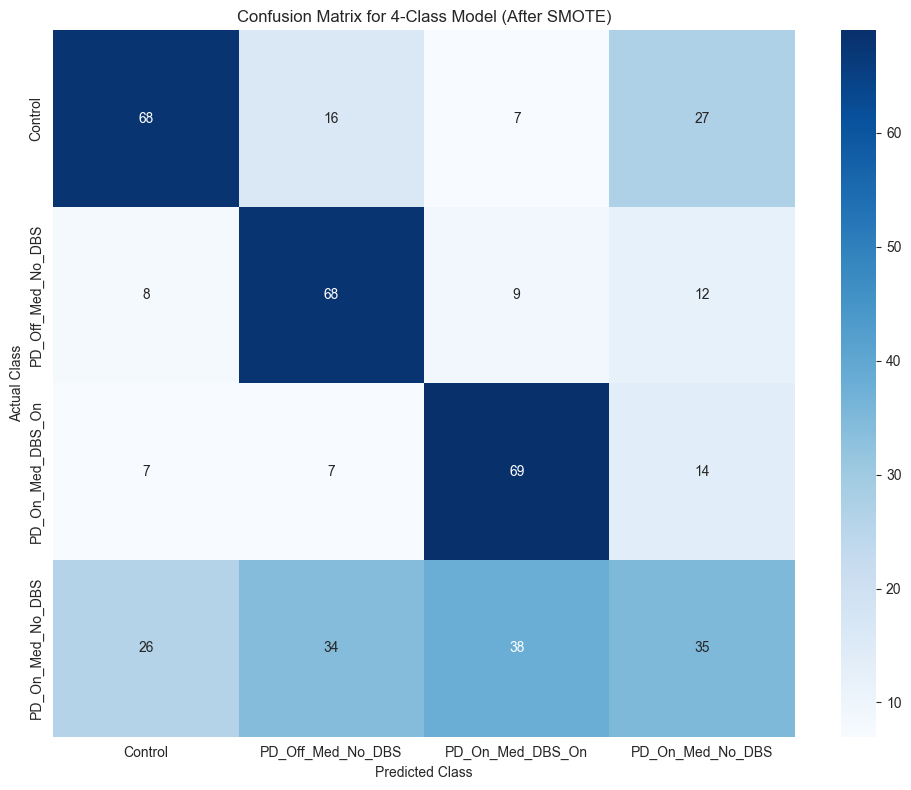

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Data ---
# Place your CSV file in the same folder as this script,
# or update the file_path to the correct location.
try:
    df_2d_features = pd.read_csv(file_path)
    print(f"✅ Successfully loaded data from '{file_path}'")
except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
    print("Please make sure the CSV file is in the correct directory and try again.")
    # Exit the script if the data cannot be loaded
    exit()

df = df_2d_features.copy()

# --- 2. Filter Data and Create Target Variable ---
# Define the list of values that mean "No DBS"
no_dbs_values = ['-', 'Off DBS'] # Includes all possibilities

# 1. Control Group
cond_c = (df['PD_or_C'] == 'C') & \
         (df['turning_angle'] == '90_degrees') & \
         (df['type_of_turn'] == 'pivot_turn')

# 2. PD, On Medication, No DBS
cond_pd_on_nodbs = (df['PD_or_C'] == 'PD') & \
                   (df['turning_angle'] == '90_degrees') & \
                   (df['type_of_turn'] == 'pivot_turn') & \
                   (df['On_or_Off_medication'] == 'On medication') & \
                   (df['DBS_state'].isin(no_dbs_values)) # MODIFIED

# 3. PD, Off Medication, No DBS
cond_pd_off_nodbs = (df['PD_or_C'] == 'PD') & \
                    (df['turning_angle'] == '90_degrees') & \
                    (df['type_of_turn'] == 'pivot_turn') & \
                    (df['On_or_Off_medication'] == 'Off medication') & \
                    (df['DBS_state'].isin(no_dbs_values)) # MODIFIED

# 4. PD, On Medication, DBS is ON
cond_pd_on_dbs = (df['PD_or_C'] == 'PD') & \
                 (df['turning_angle'] == '90_degrees') & \
                 (df['type_of_turn'] == 'pivot_turn') & \
                 (df['On_or_Off_medication'] == 'On medication') & \
                 (df['DBS_state'] == 'On DBS')

df_model = df[cond_c | cond_pd_on_nodbs | cond_pd_off_nodbs | cond_pd_on_dbs].copy()

df_model.loc[cond_c, 'Subgroup'] = 'Control'
df_model.loc[cond_pd_on_nodbs, 'Subgroup'] = 'PD_On_Med_No_DBS'
df_model.loc[cond_pd_off_nodbs, 'Subgroup'] = 'PD_Off_Med_No_DBS'
df_model.loc[cond_pd_on_dbs, 'Subgroup'] = 'PD_On_Med_DBS_On'

print("\nClass distribution for the model:")
print(df_model['Subgroup'].value_counts())


# --- 3. Define Features and Target ---
kinematic_features_2d = [
    'number_of_turning_steps',
    'duration_sec', 'pelvis_path_length', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_avg_jerk_mag', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel'
]

X = df_model[kinematic_features_2d]
y = df_model['Subgroup']

# --- 4. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- NEW STEP: Apply SMOTE to the training data ---
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Original training set distribution:\n", y_train.value_counts())
print("\nResampled training set distribution:\n", y_train_resampled.value_counts())
# --- End of new step ---

# --- 5. Scale the Features ---
scaler = StandardScaler()
# CORRECT: Fit the scaler on the RESAMPLED training data
X_train_scaled = scaler.fit_transform(X_train_resampled)
# CORRECT: Transform the original test data as before
X_test_scaled = scaler.transform(X_test)

# --- 6. Train the Random Forest Model ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
    # Note: class_weight='balanced' is no longer needed as the data is now balanced
)
# CORRECT: Train the model on the RESAMPLED and SCALED data
model.fit(X_train_scaled, y_train_resampled)
print("\n✅ Model training complete on resampled data.")

# --- 7. Evaluate the Model ---
y_pred = model.predict(X_test_scaled)

print("\n" + "="*50)
print("          Model Evaluation Results (After SMOTE)")
print("="*50)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


# --- 8. Generate and Plot Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)

plt.title('Confusion Matrix for 4-Class Model (After SMOTE)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()

# Save the plot to a file
plt.savefig('confusion_matrix_smote.png')
print("\n✅ Confusion matrix plot saved as 'confusion_matrix_smote.png'")

# Display the plot
plt.show()

✅ Successfully loaded data from 'D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_3.csv'

Class distribution for the new binary model:
Group
C     392
PD    324
Name: count, dtype: int64

Original training set distribution:
 Group
C     274
PD    227
Name: count, dtype: int64

Resampled training set distribution:
 Group
PD    274
C     274
Name: count, dtype: int64

✅ Model training complete on resampled data.

     Binary Model Evaluation: Control vs. PD Off-Med
Overall Accuracy: 83.72%

Classification Report:
              precision    recall  f1-score   support

           C       0.88      0.81      0.85       118
          PD       0.79      0.87      0.83        97

    accuracy                           0.84       215
   macro avg       0.84      0.84      0.84       215
weighted avg       0.84      0.84      0.84       215



D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


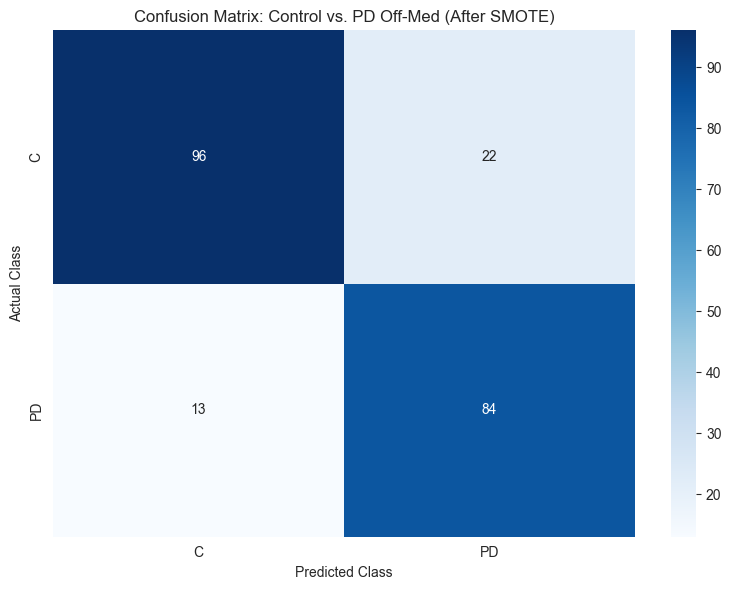

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Data ---
try:
    df_2d_features = pd.read_csv(file_path)
    print(f"✅ Successfully loaded data from '{file_path}'")
except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
    print("Please make sure the CSV file is in the correct directory and try again.")
    exit()

df = df_2d_features.copy()

# --- 2. Filter Data for Binary Classification ---
# Define the list of values that mean "No DBS"
no_dbs_values = ['-', 'Off DBS'] # Includes all possibilities

# 1. Control Group
cond_c = (df['PD_or_C'] == 'C') & \
         (df['turning_angle'] == '90_degrees') & \
         (df['type_of_turn'] == 'pivot_turn')

# 2. PD, On Medication, No DBS
cond_pd_on_nodbs = (df['PD_or_C'] == 'PD') & \
                   (df['turning_angle'] == '90_degrees') & \
                   (df['type_of_turn'] == 'pivot_turn') & \
                   (df['On_or_Off_medication'] == 'On medication') & \
                   (df['DBS_state'].isin(no_dbs_values)) # MODIFIED

# 3. PD, Off Medication, No DBS
cond_pd_off_nodbs = (df['PD_or_C'] == 'PD') & \
                    (df['turning_angle'] == '90_degrees') & \
                    (df['type_of_turn'] == 'pivot_turn') & \
                    (df['On_or_Off_medication'] == 'Off medication') & \
                    (df['DBS_state'].isin(no_dbs_values)) # MODIFIED

# 4. PD, On Medication, DBS is ON
cond_pd_on_dbs = (df['PD_or_C'] == 'PD') & \
                 (df['turning_angle'] == '90_degrees') & \
                 (df['type_of_turn'] == 'pivot_turn') & \
                 (df['On_or_Off_medication'] == 'On medication') & \
                 (df['DBS_state'] == 'On DBS')

# Filter the DataFrame to include ONLY the two specified groups
df_model = df[cond_c | cond_pd_off_nodbs].copy()

# For simplicity, we can use the original 'PD_or_C' column as our target now
# Let's rename it for clarity
df_model = df_model.rename(columns={'PD_or_C': 'Group'})

print("\nClass distribution for the new binary model:")
print(df_model['Group'].value_counts())

# --- 3. Define Features and Target ---
kinematic_features_2d = [
    # 'number_of_turning_steps',
    'duration_sec', 'pelvis_path_length', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_avg_jerk_mag', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel'
]

# kinematic_features_2d = [
#     'duration_sec',
#     'trunk_total_rotation_deg',
#     'trunk_avg_ang_vel', 'trunk_peak_ang_vel'
# ]

X = df_model[kinematic_features_2d]
y = df_model['Group'] # Our target is now the 'Group' column ('C' or 'PD')

# --- 4. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 5. Apply SMOTE to the Training Data ---
# This is still important because Control (392) and PD Off-Med (76) are imbalanced
print("\nOriginal training set distribution:\n", y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("\nResampled training set distribution:\n", y_train_resampled.value_counts())

# --- 6. Scale the Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train the Random Forest Model ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_resampled)
print("\n✅ Model training complete on resampled data.")

# --- 8. Evaluate the Model ---
y_pred = model.predict(X_test_scaled)

print("\n" + "="*60)
print("     Binary Model Evaluation: Control vs. PD Off-Med")
print("="*60)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- 9. Generate and Plot Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)

plt.title('Confusion Matrix: Control vs. PD Off-Med (After SMOTE)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()

plt.show()


          Feature Importance Analysis
Feature importances (from most to least important):
                    Feature  Importance
5  trunk_total_rotation_deg    0.168883
6         trunk_avg_ang_vel    0.139527
7        trunk_peak_ang_vel    0.135248
4       pelvis_avg_jerk_mag    0.121938
2         pelvis_peak_speed    0.120251
3      pelvis_avg_accel_mag    0.109648
1        pelvis_path_length    0.106928
0              duration_sec    0.097578


C:\Users\Kaiyang\AppData\Local\Temp\ipykernel_6920\2939159851.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


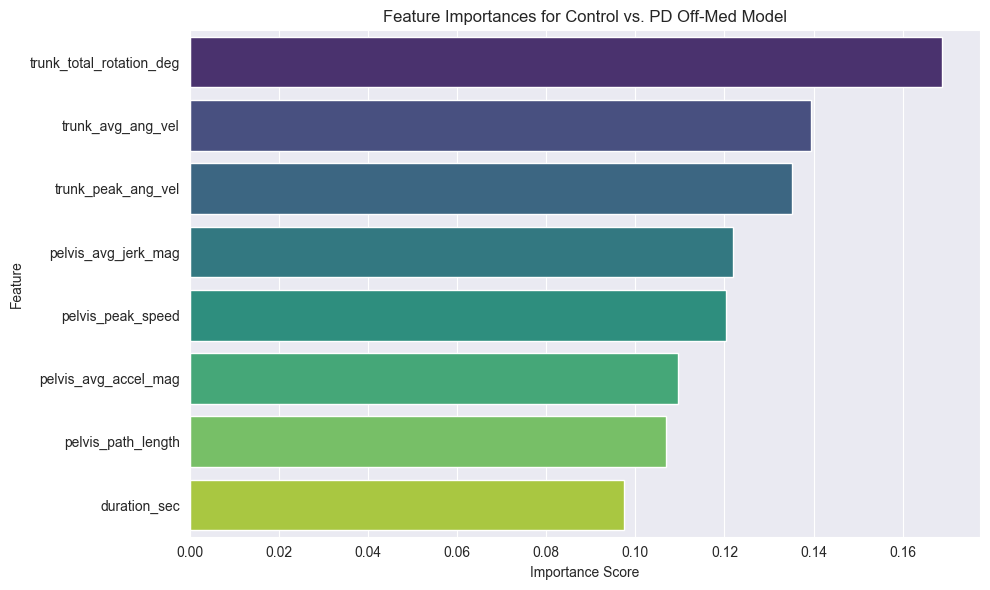

In [8]:
# --- ADD THIS CODE AFTER THE model.fit() LINE ---

print("\n" + "="*60)
print("          Feature Importance Analysis")
print("="*60)

# Get feature importances from the trained model
importances = model.feature_importances_
feature_names = X.columns # Get the feature names from the X DataFrame

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature importances (from most to least important):")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances for Control vs. PD Off-Med Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- THE REST OF YOUR EVALUATION CODE (classification_report, etc.) CAN FOLLOW ---

Generate Data Below

In [9]:
import pandas as pd
import numpy as np

# --- 1. Load and Filter Your Data ---
# Make sure this path is correct for your local machine
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\cleaned_turning_project_2d_features.csv"
df = pd.read_csv(file_path)

# Define the values that mean "No DBS"
no_dbs_values = ['No', '-', 'Off DBS']

# Define the conditions for the subgroup you want to augment
cond_pd_off_nodbs = (
    (df['PD_or_C'] == 'PD') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn') &
    (df['On_or_Off_medication'] == 'Off medication') &
    (df['DBS_state'].isin(no_dbs_values))
)

# Isolate the original data for this subgroup to use as a blueprint
blueprint_df = df[cond_pd_off_nodbs].copy()


In [10]:
# Isolate the Control group data
cond_c = (df['PD_or_C'] == 'C') & \
         (df['turning_angle'] == '90_degrees') & \
         (df['type_of_turn'] == 'pivot_turn')
control_blueprint_df = df[cond_c]

# Calculate and compare the means for a significant feature
mean_pps_pd = blueprint_df['pelvis_peak_speed'].mean()
mean_pps_control = control_blueprint_df['pelvis_peak_speed'].mean()

mean_tav_pd = blueprint_df['trunk_avg_ang_vel'].mean()
mean_tav_control = control_blueprint_df['trunk_avg_ang_vel'].mean()

print(f"Pelvis Peak Speed (Mean): PD Off = {mean_pps_pd:.2f}, Control = {mean_pps_control:.2f}")
print(f"Trunk Avg Ang Vel (Mean): PD Off = {mean_tav_pd:.2f}, Control = {mean_tav_control:.2f}")

Pelvis Peak Speed (Mean): PD Off = 230.17, Control = 255.26
Trunk Avg Ang Vel (Mean): PD Off = 4.50, Control = 3.66


In [11]:
import pandas as pd
import numpy as np

# --- 1. Load and Filter Your Data ---
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\cleaned_turning_project_2d_features.csv"
df = pd.read_csv(file_path)

# --- Define Subgroup Conditions ---
no_dbs_values = ['No', '-', 'Off DBS']

cond_pd_off_nodbs = (
    (df['PD_or_C'] == 'PD') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn') &
    (df['On_or_Off_medication'] == 'Off medication') &
    (df['DBS_state'].isin(no_dbs_values))
)

cond_c = (
    (df['PD_or_C'] == 'C') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn')
)

# Isolate the blueprints for both groups
blueprint_pd_df = df[cond_pd_off_nodbs].copy()
blueprint_control_df = df[cond_c].copy()

if blueprint_pd_df.empty:
    print("❌ Error: No samples found for the 'PD_Off_Med_No_DBS' subgroup.")
    exit()

print(f"Original number of 'PD_Off_Med_No_DBS' samples: {len(blueprint_pd_df)}")

# --- 2. Define Features and Compare Means ---
features_to_generate = [
    'number_of_turning_steps', 'duration_sec', 'pelvis_path_length', 'pelvis_displacement',
    'pelvis_avg_speed', 'pelvis_peak_speed', 'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag',
    'pelvis_avg_jerk_mag', 'trunk_total_rotation_rad', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel', 'bbox_width', 'bbox_height', 'bbox_area'
]
significant_features = ['pelvis_peak_speed', 'trunk_avg_ang_vel']

# Calculate means to determine the shift direction
mean_comparison = {}
for feature in significant_features:
    mean_pd = blueprint_pd_df[feature].mean()
    mean_control = blueprint_control_df[feature].mean()
    mean_comparison[feature] = {'pd': mean_pd, 'control': mean_control}
    print(f"Mean for '{feature}': PD Off = {mean_pd:.2f}, Control = {mean_control:.2f}")


num_synthetic_samples = 240
mean_shift_factor = 0.1 # 10% shift

# --- 3. Generate Synthetic Data with Directional Shift ---
synthetic_data = {}
for feature in features_to_generate:
    mean = blueprint_pd_df[feature].mean()
    std = blueprint_pd_df[feature].std()

    if pd.isna(std) or std == 0:
        new_values = np.full(num_synthetic_samples, mean)
    else:
        # Check if the feature is significant to decide on shifting
        if feature in significant_features:
            # Determine direction: shift up if PD mean is higher, down if lower
            if mean_comparison[feature]['pd'] > mean_comparison[feature]['control']:
                direction = 1  # Shift up
                print(f"Shifting '{feature}' mean UP")
            else:
                direction = -1 # Shift down
                print(f"Shifting '{feature}' mean DOWN")

            shifted_mean = mean + (direction * mean_shift_factor * std)
            new_values = np.random.normal(loc=shifted_mean, scale=std, size=num_synthetic_samples)
        else:
            new_values = np.random.normal(loc=mean, scale=std, size=num_synthetic_samples)

    if feature == 'number_of_turning_steps':
        new_values = np.round(new_values).astype(int)
        new_values[new_values < 1] = 1

    synthetic_data[feature] = new_values

# Create a DataFrame for the new synthetic samples
synthetic_df = pd.DataFrame(synthetic_data)

# --- 4. Add Constant Categorical Information ---
synthetic_df['PD_or_C'] = 'PD'
synthetic_df['turning_angle'] = '90_degrees'
synthetic_df['type_of_turn'] = 'pivot_turn'
synthetic_df['On_or_Off_medication'] = 'Off medication'
synthetic_df['DBS_state'] = 'Off DBS' # Assigning a consistent value for "No DBS"
synthetic_df['Subgroup'] = 'PD_Off_Med_No_DBS'

print(f"\nGenerated {len(synthetic_df)} new synthetic samples.")
print("\n--- First 5 Generated Samples ---")
print(synthetic_df[features_to_generate].head())

Original number of 'PD_Off_Med_No_DBS' samples: 84
Mean for 'pelvis_peak_speed': PD Off = 230.17, Control = 255.26
Mean for 'trunk_avg_ang_vel': PD Off = 4.50, Control = 3.66
Shifting 'pelvis_peak_speed' mean DOWN
Shifting 'trunk_avg_ang_vel' mean UP

Generated 240 new synthetic samples.

--- First 5 Generated Samples ---
   number_of_turning_steps  duration_sec  pelvis_path_length  \
0                        1      2.034905           67.550729   
1                        2      2.573928           82.742831   
2                        2      2.446117            6.616652   
3                        2      1.806218           67.370347   
4                        2      1.706956           62.708804   

   pelvis_displacement  pelvis_avg_speed  pelvis_peak_speed  \
0            36.185338         16.849580         216.565168   
1            26.504265         67.272649         311.200479   
2            44.798792         52.190880         319.321051   
3            50.407442         33.49115

In [12]:
synthetic_df

,number_of_turning_steps,duration_sec,pelvis_path_length,pelvis_displacement,pelvis_avg_speed,pelvis_peak_speed,pelvis_avg_accel_mag,pelvis_peak_accel_mag,pelvis_avg_jerk_mag,trunk_total_rotation_rad,...,trunk_peak_ang_vel,bbox_width,bbox_height,bbox_area,PD_or_C,turning_angle,type_of_turn,On_or_Off_medication,DBS_state,Subgroup
0,1,2.034905,67.550729,36.185338,16.849580,216.565168,2590.383903,15250.946584,125640.523375,0.558917,...,48.748319,95.974066,150.762473,4824.565841,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
1,2,2.573928,82.742831,26.504265,67.272649,311.200479,2652.122085,1339.403109,78399.237609,3.710571,...,5.856687,26.936944,173.340018,8144.600732,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
2,2,2.446117,6.616652,44.798792,52.190880,319.321051,3350.289330,7878.055638,147203.523661,3.919119,...,20.529200,38.297737,140.106438,9057.634077,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
3,2,1.806218,67.370347,50.407442,33.491156,285.965061,2494.082320,9210.153957,124653.041257,1.843769,...,68.243513,79.040969,120.785974,7571.522438,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
4,2,1.706956,62.708804,16.035659,30.785197,187.746511,2891.304326,13597.512384,124025.938627,2.444191,...,69.038381,57.801730,126.935218,11256.159077,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2,2.502474,85.043407,48.723655,29.620709,174.195770,2714.575504,9469.983856,116494.500636,-2.363782,...,15.573224,28.026332,122.007249,9966.628524,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
236,2,1.930547,57.307577,61.095127,54.037250,265.353556,1737.228721,11898.076692,70361.852904,4.323668,...,27.207440,55.799702,117.695679,9398.593028,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
237,2,2.121464,86.828349,30.896205,52.428545,257.865992,2040.639205,4291.383652,142828.030497,0.899065,...,-0.651434,51.827023,174.052386,7652.889428,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS
238,2,1.948979,64.852815,72.114560,37.455033,205.538443,3315.368871,6112.389951,154462.220927,-1.042256,...,-8.002071,84.457295,150.414882,8014.916226,PD,90_degrees,pivot_turn,Off medication,Off DBS,PD_Off_Med_No_DBS


In [14]:
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\combined_data_3.csv"

df_new = pd.read_csv(file_path)
# --- 5. Combine with Original Data ---
print("\n--- Combining DataFrames ---")
print(f"Shape of original data (df_new):                {df_new.shape}")
print(f"Shape of new synthetic data (synthetic_df): {synthetic_df.shape}")

# Combine the original DataFrame with the new synthetic one
combined_df = pd.concat([df_new, synthetic_df], ignore_index=True)

print(f"Shape of the combined DataFrame:            {combined_df.shape}")

# You can now use 'combined_df' for your model training
print("\n--- First 5 rows of the final combined data ---")
print(combined_df.head())
print("\n--- Last 5 rows of the final combined data (showing synthetic samples) ---")
print(combined_df.tail())


--- Combining DataFrames ---
Shape of original data (df_new):                (2371, 27)
Shape of new synthetic data (synthetic_df): (240, 22)
Shape of the combined DataFrame:            (2611, 27)

--- First 5 rows of the final combined data ---
   Turn ID  Participant ID number PD_or_C  number_of_turning_steps  \
0      0.0                  230.0       C                        4   
1      2.0                  230.0       C                        2   
2      4.0                  230.0       C                        2   
3      5.0                  230.0       C                        2   
4      7.0                  230.0       C                        2   

  turning_angle type_of_turn  turning_duration On_or_Off_medication DBS_state  \
0    90_degrees   pivot_turn          1.980999              Control   Control   
1    90_degrees   pivot_turn          1.278000              Control   Control   
2    90_degrees   pivot_turn          1.092999              Control   Control   
3    90_

In [15]:
combined_df.to_csv("combined_data_924_pdoffmed.csv", index=False)


In [87]:
import pandas as pd
from scipy.stats import mannwhitneyu

# --- 1. Load Data ---
file_path = 'cleaned_turning_project_2d_features.csv'
df = pd.read_csv(file_path)

# --- 2. Define and Filter Subgroups ---

# Condition for the Control group
cond_c = (
    (df['PD_or_C'] == 'C') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn')
)

# Condition for PD patients on medication with DBS on
cond_pd_on_dbs = (
    (df['PD_or_C'] == 'PD') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn') &
    (df['On_or_Off_medication'] == 'On medication') &
    (df['DBS_state'] == 'On DBS')
)

# Create the two DataFrames for comparison
control_df = df[cond_c]
pd_on_dbs_df = df[cond_pd_on_dbs]

print(f"Number of samples in Control group: {len(control_df)}")
print(f"Number of samples in PD_On_Med_DBS_On group: {len(pd_on_dbs_df)}\n")


# --- 3. Perform Mann-Whitney U Tests ---

# List of features to test
features_to_test = [
    'number_of_turning_steps', 'duration_sec', 'pelvis_path_length',
    'pelvis_displacement', 'pelvis_avg_speed', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag', 'pelvis_avg_jerk_mag',
    'trunk_total_rotation_rad', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel', 'bbox_width',
    'bbox_height', 'bbox_area'
]

# Store results
results = []

print("Performing Mann-Whitney U tests for each feature...")
print("Comparing: Control vs. PD On-Medication (DBS On)")

for feature in features_to_test:
    # Extract the data series for each group
    group1 = control_df[feature]
    group2 = pd_on_dbs_df[feature]

    # Perform the test
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

    results.append({
        'Feature': feature,
        'Statistic': stat,
        'P-Value': p_value
    })

# Convert results to a DataFrame for nice printing
results_df = pd.DataFrame(results)
results_df['Significant Difference (p < 0.05)'] = results_df['P-Value'] < 0.05

# --- 4. Display Results ---
print("\n" + "="*60)
print("           Mann-Whitney U Test Results")
print("="*60)
print(results_df.to_string())

Number of samples in Control group: 392
Number of samples in PD_On_Med_DBS_On group: 74

Performing Mann-Whitney U tests for each feature...
Comparing: Control vs. PD On-Medication (DBS On)

           Mann-Whitney U Test Results
                     Feature  Statistic       P-Value  Significant Difference (p < 0.05)
0    number_of_turning_steps     9347.5  1.313369e-08                               True
1               duration_sec     7743.0  1.945056e-10                               True
2         pelvis_path_length    12819.0  1.128709e-01                              False
3        pelvis_displacement    18080.0  7.646889e-04                               True
4           pelvis_avg_speed    18385.0  2.599485e-04                               True
5          pelvis_peak_speed    19612.5  1.433957e-06                               True
6       pelvis_avg_accel_mag    18537.0  1.474570e-04                               True
7      pelvis_peak_accel_mag    18837.0  4.396888e-05     

In [100]:
import pandas as pd
import numpy as np

# --- 1. Load and Filter Your Data ---
file_path = 'cleaned_turning_project_2d_features.csv'
df = pd.read_csv(file_path)

# --- Define Subgroup Conditions ---
# Condition for the Control group (for comparison)
cond_c = (
    (df['PD_or_C'] == 'C') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn')
)

# MODIFIED: Condition for the new subgroup you want to augment
cond_pd_on_dbs = (
    (df['PD_or_C'] == 'PD') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn') &
    (df['On_or_Off_medication'] == 'On medication') &
    (df['DBS_state'] == 'On DBS')
)

# Isolate the blueprints for both groups
blueprint_pd_df = df[cond_pd_on_dbs].copy()
blueprint_control_df = df[cond_c].copy()

if blueprint_pd_df.empty:
    print("❌ Error: No samples found for the 'PD_On_Med_DBS_On' subgroup.")
    exit()

print(f"Original number of 'PD_On_Med_DBS_On' samples: {len(blueprint_pd_df)}")

# --- 2. Define Features and Compare Means ---
features_to_generate = [
    'number_of_turning_steps', 'duration_sec', 'pelvis_path_length', 'pelvis_displacement',
    'pelvis_avg_speed', 'pelvis_peak_speed', 'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag',
    'pelvis_avg_jerk_mag', 'trunk_total_rotation_rad', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel', 'bbox_width', 'bbox_height', 'bbox_area'
]

# MODIFIED: Updated list of significant features based on the new test
significant_features = [
    'number_of_turning_steps', 'duration_sec', 'pelvis_displacement',
    'pelvis_avg_speed', 'pelvis_peak_speed', 'pelvis_avg_accel_mag',
    'pelvis_peak_accel_mag', 'pelvis_avg_jerk_mag', 'trunk_avg_ang_vel'
]

# Calculate means to determine the shift direction
mean_comparison = {}
for feature in significant_features:
    mean_pd = blueprint_pd_df[feature].mean()
    mean_control = blueprint_control_df[feature].mean()
    mean_comparison[feature] = {'pd': mean_pd, 'control': mean_control}
    print(f"Mean for '{feature}': PD On (DBS) = {mean_pd:.2f}, Control = {mean_control:.2f}")

num_synthetic_samples = 250 # You can change this number
mean_shift_factor = 0.1   # How much to shift the mean (10% of std dev)

# --- 3. Generate Synthetic Data with Directional Shift ---
synthetic_data = {}
for feature in features_to_generate:
    mean = blueprint_pd_df[feature].mean()
    std = blueprint_pd_df[feature].std()

    if pd.isna(std) or std == 0:
        new_values = np.full(num_synthetic_samples, mean)
    else:
        if feature in significant_features:
            if mean_comparison[feature]['pd'] > mean_comparison[feature]['control']:
                direction = 1 # Shift up
            else:
                direction = -1 # Shift down

            shifted_mean = mean + (direction * mean_shift_factor * std)
            new_values = np.random.normal(loc=shifted_mean, scale=std, size=num_synthetic_samples)
        else:
            new_values = np.random.normal(loc=mean, scale=std, size=num_synthetic_samples)

    if feature == 'number_of_turning_steps':
        new_values = np.round(new_values).astype(int)
        new_values[new_values < 1] = 1

    synthetic_data[feature] = new_values

# Create a DataFrame for the new synthetic samples
synthetic_df = pd.DataFrame(synthetic_data)

# --- 4. Add the Constant Categorical Information ---
synthetic_df['PD_or_C'] = 'PD'
synthetic_df['turning_angle'] = '90_degrees'
synthetic_df['type_of_turn'] = 'pivot_turn'
synthetic_df['On_or_Off_medication'] = 'On medication'
synthetic_df['DBS_state'] = 'On DBS' # Assign the correct value
synthetic_df['Subgroup'] = 'PD_On_Med_DBS_On' # Assign the correct label

print(f"\nGenerated {len(synthetic_df)} new synthetic samples for 'PD_On_Med_DBS_On'.")
print("\n--- First 5 Generated Samples ---")
# Display only the generated feature columns for brevity
print(synthetic_df[features_to_generate].head())

Original number of 'PD_On_Med_DBS_On' samples: 74
Mean for 'number_of_turning_steps': PD On (DBS) = 2.30, Control = 1.80
Mean for 'duration_sec': PD On (DBS) = 2.52, Control = 2.02
Mean for 'pelvis_displacement': PD On (DBS) = 30.09, Control = 37.66
Mean for 'pelvis_avg_speed': PD On (DBS) = 37.74, Control = 43.50
Mean for 'pelvis_peak_speed': PD On (DBS) = 205.29, Control = 255.26
Mean for 'pelvis_avg_accel_mag': PD On (DBS) = 2050.54, Control = 2368.12
Mean for 'pelvis_peak_accel_mag': PD On (DBS) = 7544.17, Control = 8859.77
Mean for 'pelvis_avg_jerk_mag': PD On (DBS) = 112751.79, Control = 130547.62
Mean for 'trunk_avg_ang_vel': PD On (DBS) = 2.74, Control = 3.66

Generated 250 new synthetic samples for 'PD_On_Med_DBS_On'.

--- First 5 Generated Samples ---
   number_of_turning_steps  duration_sec  pelvis_path_length  \
0                        2      3.358848           44.404675   
1                        3      3.075283           96.594853   
2                        3      1.95

In [101]:
synthetic_df

,number_of_turning_steps,duration_sec,pelvis_path_length,pelvis_displacement,pelvis_avg_speed,pelvis_peak_speed,pelvis_avg_accel_mag,pelvis_peak_accel_mag,pelvis_avg_jerk_mag,trunk_total_rotation_rad,...,trunk_peak_ang_vel,bbox_width,bbox_height,bbox_area,PD_or_C,turning_angle,type_of_turn,On_or_Off_medication,DBS_state,Subgroup
0,2,3.358848,44.404675,42.925778,36.717666,196.866231,2164.283647,7956.801329,101298.056158,1.123219,...,29.051763,108.779716,151.669522,12847.330525,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
1,3,3.075283,96.594853,30.932305,24.936409,220.098548,1289.894155,9408.682951,102507.537245,0.030632,...,30.153108,84.580649,131.810489,4457.044423,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
2,3,1.959787,153.876829,37.863026,40.384681,308.086133,1565.265592,7122.674344,117069.015063,1.872633,...,11.260576,79.140053,154.895579,9871.857873,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
3,2,2.549230,119.182592,21.559004,53.311979,211.836677,2287.833218,6764.423950,138854.483330,3.341177,...,26.480183,61.197483,151.542960,9216.661167,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
4,2,1.437176,93.452823,21.288365,37.946285,293.157468,2421.304430,8218.975022,89477.887964,1.611995,...,40.626508,84.647916,143.398849,7842.783899,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2,2.827155,152.200304,8.419102,18.923099,140.547574,2856.180498,1938.226025,117964.834780,3.511278,...,14.423986,45.621905,134.931582,13140.832072,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
246,2,2.670934,28.561512,23.707708,37.304215,232.938071,1757.468647,3073.909877,90200.562295,1.340498,...,-9.033966,74.267267,111.619766,12881.745563,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
247,2,1.444729,98.105492,20.401015,32.025667,154.077370,1704.943941,6784.452881,113138.169539,2.610969,...,37.702482,104.351780,132.533057,7338.774868,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On
248,3,2.915437,81.117904,32.356735,21.995349,185.944160,1954.278232,5225.423852,82869.233805,0.848505,...,14.564449,93.153118,139.360732,6292.276208,PD,90_degrees,pivot_turn,On medication,On DBS,PD_On_Med_DBS_On


In [102]:
# --- 5. Combine with Original Data ---
print("\n--- Combining DataFrames ---")
print(f"Shape of original data (df):                {df.shape}")
print(f"Shape of new synthetic data (synthetic_df): {synthetic_df.shape}")

# Combine the original DataFrame with the new synthetic one
combined_df_1 = pd.concat([combined_df, synthetic_df], ignore_index=True)

print(f"Shape of the combined DataFrame:            {combined_df_1.shape}")

# You can now use 'combined_df' for your model training
print("\n--- First 5 rows of the final combined data ---")
print(combined_df_1.head())
print("\n--- Last 5 rows of the final combined data (showing synthetic samples) ---")
print(combined_df_1.tail())


--- Combining DataFrames ---
Shape of original data (df):                (1681, 26)
Shape of new synthetic data (synthetic_df): (250, 22)
Shape of the combined DataFrame:            (2171, 27)

--- First 5 rows of the final combined data ---
   Turn ID  Participant ID number PD_or_C  number_of_turning_steps  \
0      0.0                  230.0       C                        4   
1      2.0                  230.0       C                        2   
2      4.0                  230.0       C                        2   
3      5.0                  230.0       C                        2   
4      7.0                  230.0       C                        2   

  turning_angle type_of_turn  turning_duration On_or_Off_medication DBS_state  \
0    90_degrees   pivot_turn          1.980999              Control   Control   
1    90_degrees   pivot_turn          1.278000              Control   Control   
2    90_degrees   pivot_turn          1.092999              Control   Control   
3    90_degr

In [103]:
combined_df_1.to_csv("combined_data_2.csv", index=False)


In [106]:
import pandas as pd
from scipy.stats import mannwhitneyu

# --- 1. Load Data ---
# Make sure this path is correct for your local machine
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\cleaned_turning_project_2d_features.csv"
try:
    df = pd.read_csv(file_path)
    print(f"✅ Successfully loaded data from '{file_path}'")
except FileNotFoundError:
    print(f"❌ Error: The file was not found. Please check the path.")
    exit()


# --- 2. Define and Filter Subgroups ---

# Condition for the Control group
cond_c = (
    (df['PD_or_C'] == 'C') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn')
)

# Condition for PD patients on medication with NO DBS
# Using .isin() to handle multiple possible values like 'No', '-', or 'Off DBS'
no_dbs_values = ['No', '-', 'Off DBS']
cond_pd_on_nodbs = (
    (df['PD_or_C'] == 'PD') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn') &
    (df['On_or_Off_medication'] == 'On medication') &
    (df['DBS_state'].isin(no_dbs_values))
)

# Create the two DataFrames for comparison
control_df = df[cond_c]
pd_on_nodbs_df = df[cond_pd_on_nodbs]

# --- Safety Check: Ensure data was found for both groups ---
if control_df.empty or pd_on_nodbs_df.empty:
    print("❌ Error: One or both of the subgroups are empty. Cannot perform test.")
    print(f"Control samples found: {len(control_df)}")
    print(f"PD On-Med (No DBS) samples found: {len(pd_on_nodbs_df)}")
    exit()

print(f"Number of samples in Control group: {len(control_df)}")
print(f"Number of samples in PD_On_Med_No_DBS group: {len(pd_on_nodbs_df)}\n")


# --- 3. Perform Mann-Whitney U Tests ---

# List of features to test
features_to_test = [
    'number_of_turning_steps', 'duration_sec', 'pelvis_path_length',
    'pelvis_displacement', 'pelvis_avg_speed', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag', 'pelvis_avg_jerk_mag',
    'trunk_total_rotation_rad', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel', 'bbox_width',
    'bbox_height', 'bbox_area'
]

results = []

print("Performing Mann-Whitney U tests for each feature...")
print("Comparing: Control vs. PD On-Medication (No DBS)")

for feature in features_to_test:
    group1 = control_df[feature]
    group2 = pd_on_nodbs_df[feature]

    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

    results.append({
        'Feature': feature,
        'Statistic': stat,
        'P-Value': p_value
    })

results_df = pd.DataFrame(results)
results_df['Significant Difference (p < 0.05)'] = results_df['P-Value'] < 0.05

# --- 4. Display Results ---
print("\n" + "="*60)
print("           Mann-Whitney U Test Results")
print("="*60)
# Using .to_string() ensures the full table is printed
print(results_df.to_string())

✅ Successfully loaded data from 'D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\cleaned_turning_project_2d_features.csv'
Number of samples in Control group: 392
Number of samples in PD_On_Med_No_DBS group: 242

Performing Mann-Whitney U tests for each feature...
Comparing: Control vs. PD On-Medication (No DBS)

           Mann-Whitney U Test Results
                     Feature  Statistic   P-Value  Significant Difference (p < 0.05)
0    number_of_turning_steps    42770.5  0.014113                               True
1               duration_sec    37274.0  0.000006                               True
2         pelvis_path_length    48798.0  0.542220                              False
3        pelvis_displacement    53622.0  0.005734                               True
4           pelvis_avg_speed    55645.0  0.000247                               True
5          pelvis_peak_speed    57004.0  0.000018                               True
6       pelvis_avg_accel_mag    55553

In [107]:
import pandas as pd
import numpy as np

# --- 1. Load and Filter Your Data ---
# Make sure this path is correct for your local machine
file_path = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\cleaned_turning_project_2d_features.csv"
df = pd.read_csv(file_path)

# --- Define Subgroup Conditions ---
# Using the robust list you provided for "No DBS"
no_dbs_values = ['No', '-', 'Off DBS']

cond_pd_on_nodbs = (
    (df['PD_or_C'] == 'PD') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn') &
    (df['On_or_Off_medication'] == 'On medication') &
    (df['DBS_state'].isin(no_dbs_values))
)

cond_c = (
    (df['PD_or_C'] == 'C') &
    (df['turning_angle'] == '90_degrees') &
    (df['type_of_turn'] == 'pivot_turn')
)

# Isolate the blueprints for both groups
blueprint_pd_df = df[cond_pd_on_nodbs].copy()
blueprint_control_df = df[cond_c].copy()

if blueprint_pd_df.empty:
    print("❌ Error: No samples found for the 'PD_On_Med_No_DBS' subgroup.")
    print("Please check your filter conditions and CSV file to ensure they match.")
    exit()

print(f"Original number of 'PD_On_Med_No_DBS' samples: {len(blueprint_pd_df)}")

# --- 2. Define Features and Compare Means ---
features_to_generate = [
    'number_of_turning_steps', 'duration_sec', 'pelvis_path_length', 'pelvis_displacement',
    'pelvis_avg_speed', 'pelvis_peak_speed', 'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag',
    'pelvis_avg_jerk_mag', 'trunk_total_rotation_rad', 'trunk_total_rotation_deg',
    'trunk_avg_ang_vel', 'trunk_peak_ang_vel', 'bbox_width', 'bbox_height', 'bbox_area'
]

# MODIFIED: Updated list of significant features based on the latest test
significant_features = [
    'duration_sec', 'pelvis_displacement', 'pelvis_avg_speed', 'pelvis_peak_speed',
    'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag', 'pelvis_avg_jerk_mag'
]

# Calculate means to determine the shift direction
mean_comparison = {}
for feature in significant_features:
    mean_pd = blueprint_pd_df[feature].mean()
    mean_control = blueprint_control_df[feature].mean()
    mean_comparison[feature] = {'pd': mean_pd, 'control': mean_control}
    print(f"Mean for '{feature}': PD On (No DBS) = {mean_pd:.2f}, Control = {mean_control:.2f}")

num_synthetic_samples = 200
mean_shift_factor = 0.1

# --- 3. Generate Synthetic Data with Directional Shift ---
synthetic_data = {}
for feature in features_to_generate:
    mean = blueprint_pd_df[feature].mean()
    std = blueprint_pd_df[feature].std()

    if pd.isna(std) or std == 0:
        new_values = np.full(num_synthetic_samples, mean)
    else:
        if feature in significant_features:
            if mean_comparison[feature]['pd'] > mean_comparison[feature]['control']:
                direction = 1
            else:
                direction = -1

            shifted_mean = mean + (direction * mean_shift_factor * std)
            new_values = np.random.normal(loc=shifted_mean, scale=std, size=num_synthetic_samples)
        else:
            new_values = np.random.normal(loc=mean, scale=std, size=num_synthetic_samples)

    if feature == 'number_of_turning_steps':
        new_values = np.round(new_values).astype(int)
        new_values[new_values < 1] = 1

    synthetic_data[feature] = new_values

# Create a DataFrame for the new synthetic samples
synthetic_df = pd.DataFrame(synthetic_data)

# --- 4. Add the Constant Categorical Information ---
synthetic_df['PD_or_C'] = 'PD'
synthetic_df['turning_angle'] = '90_degrees'
synthetic_df['type_of_turn'] = 'pivot_turn'
synthetic_df['On_or_Off_medication'] = 'On medication'
synthetic_df['DBS_state'] = 'Off DBS' # Assigning a consistent value for "No DBS"
synthetic_df['Subgroup'] = 'PD_On_Med_No_DBS'

print(f"\nGenerated {len(synthetic_df)} new synthetic samples for 'PD_On_Med_No_DBS'.")
print("\n--- First 5 Generated Samples ---")
print(synthetic_df.head())

Original number of 'PD_On_Med_No_DBS' samples: 242
Mean for 'duration_sec': PD On (No DBS) = 2.19, Control = 2.02
Mean for 'pelvis_displacement': PD On (No DBS) = 33.88, Control = 37.66
Mean for 'pelvis_avg_speed': PD On (No DBS) = 39.88, Control = 43.50
Mean for 'pelvis_peak_speed': PD On (No DBS) = 223.47, Control = 255.26
Mean for 'pelvis_avg_accel_mag': PD On (No DBS) = 2176.02, Control = 2368.12
Mean for 'pelvis_peak_accel_mag': PD On (No DBS) = 7967.68, Control = 8859.77
Mean for 'pelvis_avg_jerk_mag': PD On (No DBS) = 119868.19, Control = 130547.62

Generated 200 new synthetic samples for 'PD_On_Med_No_DBS'.

--- First 5 Generated Samples ---
   number_of_turning_steps  duration_sec  pelvis_path_length  \
0                        2      1.356162           56.641032   
1                        2      1.966484           58.192696   
2                        2      2.040755           88.314232   
3                        1      2.474956           36.974508   
4                     

In [108]:
# --- 5. Combine with Original Data ---
print("\n--- Combining DataFrames ---")
print(f"Shape of original data (df):                {df.shape}")
print(f"Shape of new synthetic data (synthetic_df): {synthetic_df.shape}")

# Combine the original DataFrame with the new synthetic one
combined_df_2 = pd.concat([combined_df_1, synthetic_df], ignore_index=True)

print(f"Shape of the combined DataFrame:            {combined_df_2.shape}")

# You can now use 'combined_df' for your model training
print("\n--- First 5 rows of the final combined data ---")
print(combined_df_2.head())
print("\n--- Last 5 rows of the final combined data (showing synthetic samples) ---")
print(combined_df_2.tail())


--- Combining DataFrames ---
Shape of original data (df):                (1681, 26)
Shape of new synthetic data (synthetic_df): (200, 22)
Shape of the combined DataFrame:            (2371, 27)

--- First 5 rows of the final combined data ---
   Turn ID  Participant ID number PD_or_C  number_of_turning_steps  \
0      0.0                  230.0       C                        4   
1      2.0                  230.0       C                        2   
2      4.0                  230.0       C                        2   
3      5.0                  230.0       C                        2   
4      7.0                  230.0       C                        2   

  turning_angle type_of_turn  turning_duration On_or_Off_medication DBS_state  \
0    90_degrees   pivot_turn          1.980999              Control   Control   
1    90_degrees   pivot_turn          1.278000              Control   Control   
2    90_degrees   pivot_turn          1.092999              Control   Control   
3    90_degr

In [109]:
combined_df_2.to_csv("combined_data_3.csv", index=False)
